<a href="https://colab.research.google.com/github/samson7722/ENDG-511/blob/main/ENDG_511_LAB_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ENDG 511 Lab 3 Assignment: Advanced Model Optimization**

This colab notebook provides code and a framework for ***Lab 3***. You can work out your solutions here.


## Goals

In this lab, you will be introduced to advanced implmentations of the model optimization methods presented in Lab 2, and you will learn how to use them to create more efficient deep learning models. Model optimization is key when deploying deep learning models in resource-constrained IoT hardware and for low-latency sensing applications. You will also have the opportunity to explore other advanced methods. The goals of this lab are:

- Understand the basics of iterative pruning and how to develop an iterative pruning schedule
- Apply iterative pruning and weight clustering to an MNIST model.
- Become familiar with applying any method of TensorFlow Model Optimization Toolkit's (https://www.tensorflow.org/model_optimization/guide/) by reviewing the examples and implementing them yourself.
- Understand and apply quantization aware training to an MNIST model (optional)

## Layout
This lab is split into **three** parts.
- **Part 1**: Apply iterative pruning to an MNIST model and evaluate the pruned model.
- **Part 2 (Optional - no marks)**: Apply quantization aware training and evaluate the quantized model.
- **Part 3**: Apply weight clustering alone and then combine weight clustering with iterative pruning.

## How to submit the Assignment

- You are required to sumbmit the completed python notebook and a pdf version of it in a Dropbox folder on D2L.
- This is an individual assignment, and all the assignements must be submitted individually.
- This assignment can be completed directly on Google Colab, but you are free to choose any other computing resource.
-  Lab sessions will be held to go over the main concepts and help you with the assignment.


# **Part 1**: Iterative Pruning

This part of the lab demonstrates applying iterative pruning to a neural network to reduce size and inference while maintaining a high accuracy compared to the original neural network. At a high level, the steps required to implement iterative pruning and evaluate a model are as follows:

- Build and train the dense baseline
- Prune the model (but not till the target sparsity)
- Train the pruned model
- Repeat steps 2 and 3 until the target sparsity is reached.
- Evaluate the final model

One advantage of iterative pruning over one-shot pruning (which was demonstrated in Lab 2) is that it allows for more fine-grained control over the compression process. By retraining the network after each pruning step, the model is able to adapt to the pruning and maintain its performance on the target task. The image below can help you visualize iterative pruning:

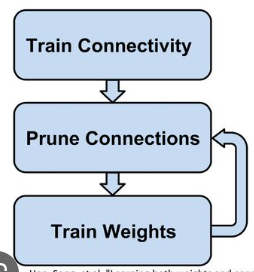

### Import and install all required modules

In [36]:
!pip install -q tensorflow-model-optimization

import tempfile
import os
import time

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

from tensorflow import keras
import tensorflow_model_optimization as tfmot

### Build and Train a neural network for MNIST without pruning

Similar to the examples presented in Lab1 we will build and train a neural network for the MNIST dataset without any model optimization. This will be our base model for the remainder of this lab. We also save the model before training - you can choose to use this untrained model in the exercises.


In [37]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture.
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

# Save untrained model
model.save('untrained_base_model.h5')

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_split=0.1,
)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/5
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3166 - accuracy: 0.9077 - val_loss: 0.1308 - val_accuracy: 0.9645
Epoch 2/5
1688/1688 [==============================] - 8s 5ms/step - loss: 0.1530 - accuracy: 0.9541 - val_loss: 0.0937 - val_accuracy: 0.9755
Epoch 3/5
1688/1688 [==============================] - 10s 6ms/step - loss: 0.1145 - accuracy: 0.9649 - val_loss: 0.0793 - val_accuracy: 0.9770
Epoch 4/5
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0933 - accuracy: 0.9710 - val_loss: 0.0717 - val_accuracy: 0.9792
Epoch 5/5
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0767 - accuracy: 0.9755 - val_loss: 0.0676 - val_accuracy: 0.9825


Let's display the architecture of our model:

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Save model
Let us save the trained model so that we can evaluate it at a later stage.

In [39]:
# Save your trained model
model.save('trained_base_model.h5')

### Define Iterative Pruning Function
We define a function that takes an unpruned model along with other parameteres, performs iterative pruning and returns the pruned model. These are parameters of iterative pruning along with their explanation.

The **Polynomial Decay** pruning schedule: the degree of sparsity is changed during training and it is not kept constant.

**initial_sparsity**: The initial sparsity is the sparsity of the model at the beginning of the iterative pruning procedure. If a none zero value is provided, the model is one-shot pruned to the initial sparsity at the beginning.

**final_sparsity**: This is the final target sparsity of the model.

**begin_step**: The training step where iterative pruning will start to be applied. At this step the model is pruned to the initial sparsity value.

**end_step**: The last training step where iterative pruning will be applied. After this step has been completed the model would have reached its final sparsity.

**frequency**: How often to apply pruning

**power**: The default is linear. This is the power of the polynomial function and how the sparsity changes from the initial sparsity at the begin step to the final sparsity at the end step

Number of Steps per Epoch = (Total Number of Training Samples) / (Batch Size)

You need to make sure to choose a begin_step and end_step that are not out of the range of the training steps.


In [40]:
def iterative_pruning(model, initial_sparsity, final_sparsity, begin_step, end_step, train_images, train_labels, epochs):
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Define model for pruning.
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=initial_sparsity,
        final_sparsity=final_sparsity, begin_step=begin_step, end_step=end_step, frequency=100)
  }

  pruned_model = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
  pruned_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])


  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
  ]

  pruned_model.fit(train_images, train_labels, epochs=epochs, validation_split=0.1,
                    callbacks=callbacks)

  # Strip pruning wrappers
  stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

  return pruned_model, stripped_pruned_model

In [41]:
pruned_model, stripped_pruned_model = iterative_pruning(model, 0, 0.5, 0, 3000, train_images, train_labels, 3)

Epoch 1/3
1688/1688 [==============================] - 15s 7ms/step - loss: 0.0707 - accuracy: 0.9774 - val_loss: 0.0679 - val_accuracy: 0.9802
Epoch 2/3
1688/1688 [==============================] - 14s 8ms/step - loss: 0.0613 - accuracy: 0.9805 - val_loss: 0.0662 - val_accuracy: 0.9813
Epoch 3/3
1688/1688 [==============================] - 11s 7ms/step - loss: 0.0538 - accuracy: 0.9830 - val_loss: 0.0646 - val_accuracy: 0.9817


In [42]:
stripped_pruned_model.save('stripped_pruned_model.h5')

### Confirm that pruning was correctly applied

In [43]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )
print_model_weights_sparsity(stripped_pruned_model)

dense_2/kernel:0: 50.00% sparsity  (50176/100352)
dense_3/kernel:0: 50.00% sparsity  (640/1280)


### Evaluate the model
Finally, we compare the pruned model to the base model. We can see that the accuracy and inference time is comparable, however, the pruned model is much smaller in size.

Note: Pruning is capable of improving inference time significantly, however, additional libraries and modifications are needed to see inference improvements as a result of pruning (Pruning inference improvements is very hardware specific!). If you are curious you can read this paper which explains how sparse models can be used to accelerate inference (https://arxiv.org/pdf/1911.09723.pdf)

In [44]:
# Evaluate prediction accuracy
model = tf.keras.models.load_model('trained_base_model.h5')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)
test_loss_pruned_50, test_acc_pruned_50 = pruned_model.evaluate(test_images,  test_labels, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_model.predict(test_images)
executionTimePruned50 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_base_model.h5')
## Print without stripping
pruned_model_size = get_gzipped_model_size('stripped_pruned_model.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

print('\nPruned Model Accuracy:', test_acc_pruned_50*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size))
print("Pruned Inference Time is", executionTimePruned50, "s")

313/313 [==============================] - 1s 2ms/step

Base Model Accuracy: 97.78000116348267 %
Base Model Size: 374933.00 bytes
Base Inference Time is 7.51723289489746e-05 s

Pruned Model Accuracy: 98.00000190734863 %
Pruned Model Size: 234614.00 bytes
Pruned Inference Time is 7.499771118164062e-05 s


### Excercie: (1 points)


Question 1: Apply the iterative pruning function provided above with a final sparsity of 90%. For the paramters of the iterative pruning function choose suitable values that make sense and give reasons for your choices. Compare the accuracy of the iterative pruned 90% model to the one-shot pruned 90% model from Lab3. Next, apply iterative pruning to a final sparsity of 95% and try to minimize any accuracy loss. ***(1.5 points)***

In [45]:
pruned_model_90, stripped_pruned_model_90 = iterative_pruning(model,0,0.9,1200,3500, train_images,train_labels,3)

Epoch 1/3
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0720 - accuracy: 0.9772 - val_loss: 0.0667 - val_accuracy: 0.9808
Epoch 2/3
1688/1688 [==============================] - 7s 4ms/step - loss: 0.1902 - accuracy: 0.9441 - val_loss: 0.1439 - val_accuracy: 0.9657
Epoch 3/3
1688/1688 [==============================] - 8s 5ms/step - loss: 0.2244 - accuracy: 0.9329 - val_loss: 0.1196 - val_accuracy: 0.9695


In [46]:
stripped_pruned_model_90.save('Stripped_pruned_model_90.h5')

In [47]:
# Evaluate prediction accuracy
model = tf.keras.models.load_model('trained_base_model.h5')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)
test_loss_pruned_90, test_acc_pruned_90 = pruned_model_90.evaluate(test_images,  test_labels, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_model_90.predict(test_images)
executionTimePruned90 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_base_model.h5')
## Print without stripping
pruned_model_size = get_gzipped_model_size('Stripped_pruned_model_90.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

print('\nPruned Model Accuracy:', test_acc_pruned_90*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size))
print("Pruned Inference Time is", executionTimePruned90, "s")

313/313 [==============================] - 1s 2ms/step

Base Model Accuracy: 97.78000116348267 %
Base Model Size: 374933.00 bytes
Base Inference Time is 7.753286361694336e-05 s

Pruned Model Accuracy: 96.10000252723694 %
Pruned Model Size: 77725.00 bytes
Pruned Inference Time is 7.783617973327636e-05 s


In [48]:
pruned_model_95, stripped_pruned_model_95 = iterative_pruning(model,0,0.95,1200 ,3500, train_images,train_labels,3)
stripped_pruned_model_95.save('Stripped_pruned_model_95.h5')

Epoch 1/3
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0703 - accuracy: 0.9782 - val_loss: 0.0692 - val_accuracy: 0.9795
Epoch 2/3
1688/1688 [==============================] - 8s 5ms/step - loss: 0.3334 - accuracy: 0.9006 - val_loss: 0.3226 - val_accuracy: 0.9238
Epoch 3/3
1688/1688 [==============================] - 7s 4ms/step - loss: 0.4956 - accuracy: 0.8474 - val_loss: 0.2508 - val_accuracy: 0.9335


In [49]:
# Evaluate prediction accuracy
model = tf.keras.models.load_model('trained_base_model.h5')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)
test_loss_pruned_95, test_acc_pruned_95 = pruned_model_95.evaluate(test_images,  test_labels, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_model_95.predict(test_images)
executionTimePruned95 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_base_model.h5')
## Print without stripping
pruned_model_size = get_gzipped_model_size('Stripped_pruned_model_95.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

print('\nPruned Model Accuracy:', test_acc_pruned_95*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size))
print("Pruned Inference Time is", executionTimePruned95, "s")

313/313 [==============================] - 1s 2ms/step

Base Model Accuracy: 97.78000116348267 %
Base Model Size: 374933.00 bytes
Base Inference Time is 9.033632278442383e-05 s

Pruned Model Accuracy: 92.23999977111816 %
Pruned Model Size: 54665.00 bytes
Pruned Inference Time is 7.938580513000489e-05 s


Answer:

COmparing the models two we find that the 90% pruned model has a very similar accuracy to the one in lab 2. we take a similar approach that shouldnt adjust it too much.

Now looking at compaing the (90% and 95% prunign and trying to optimize their accuracy scores. we find the 90% pruned model to be more accurate by about 4%. to accomplish the optimization for the two scenarios we utilized iterative pruning and optomized the paramneters to achieve the best accuracy scores.

# **Part 2**:  Quantization Aware Training - Optional (Code Provided)

This part of the lab demonstrates applying quantization aware training to a neural network to reduce size and inference while maintaining a high accuracy.

In quantization aware training, the quantization process is integrated into the training loop, so the model is optimized to perform well after quantization. This is different from post-training quantization (Lab 3) where quantization is applied in the end after training. This helps to reduce the gap between floating-point and quantized performance, and enables the deployment of deep learning models on low-power, low-memory devices.


At a high level, the steps required to quantize and evaluate a model are as follows:

- Build and train the dense baseline
- Fine tune the model by applying the quantization aware training API, see the accuracy, and export a quantization aware model.
- Apply quantization during conversion to TFLite
- Evaluate the model


Note: a quantization aware model is not actually quantized. Creating a quantized model is a separate step.

### Load base model
First, let us load the base model we have trained earlier.

In [50]:
model_to_quantize = tf.keras.models.load_model('trained_base_model.h5')
model_to_quantize.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Define Quantization Aware Training function

For quantization aware training, we first train a quantization aware model (from the original trained model) using a subset of the training data. The quantization aware model is then converted to a TFLite model and quantized. The quantized weights are usually more accurate as the model was "quantization aware" prior to the quantization operation.

By default, the TensorFlow QAT APIs assume 8-bit quantization.

In [51]:
def quantization_aware_training(model, x_train, y_train):
    quantize_model = tfmot.quantization.keras.quantize_model

    # q_aware stands for for quantization aware.
    q_aware_model = quantize_model(model)

    # `quantize_model` requires a recompile.
    q_aware_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    q_aware_model.summary()

    train_images_subset = x_train[0:10000] # out of 60000
    train_labels_subset = y_train[0:10000]

    ## Note that the resulting model is quantization aware but not quantized (e.g. the weights are float32 instead of int8)
    q_aware_model.fit(train_images_subset, train_labels_subset,
                  batch_size=500, epochs=5, validation_split=0.1)

    # Note: a quantization aware model is not actually quantized. Creating a quantized model is a separate step.
    ## Convert the quantization aware model to TFLite and apply quantization through the optimization options
    converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    quantized_tflite_model = converter.convert()

    return quantized_tflite_model

In [54]:
quantized_tflite_model = quantization_aware_training(model_to_quantize, train_images, train_labels)

ValueError: Unable to clone model. This generally happens if you used custom Keras layers or objects in your model. Please specify them via `quantize_scope` for your calls to `quantize_model` and `quantize_apply`. [Layer <tf_keras.src.layers.reshaping.flatten.Flatten object at 0x797f6c28b220> supplied to wrapper is not a supported layer type. Please ensure wrapped layer is a valid Keras layer.].

### Save TFLite model and load model into an interpeter
First we save the TFLite model, this will allow us to load it into an interpreter. To perform an inference with a TensorFlow Lite model, you must run it through an interpreter. The TensorFlow Lite interpreter is designed to be lean and fast.
You can find more information on the TFLite interpeter here: https://www.tensorflow.org/lite/guide/inference

In [ ]:
# Save TFLite Model
with open('quantized_tflite_model.tflite', 'wb') as f:
  f.write(quantized_tflite_model)
# Load model into interpeter
interpreter_quant = tf.lite.Interpreter(model_path=str('quantized_tflite_model.tflite'))
interpreter_quant.allocate_tensors()

### Evaluate the model
Finally, we evaluate the quantization aware model in terms of accuracy, inference time and model size. There is a very slight difference accuracy compared to Lab2, the reason is the model performs extremely well with post-training quantization that even when doing quantization aware training the benefits are minimal. Furthermore, the model trained is not very complex and therefore the added benefits of QAT are not very evident. For models that see a significant drop in accuracy due to post training quatnization, quantization aware training may be capable of producing better accuracy with no impact to model size or inference time.

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter, model_path):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    startTime = time.time()
    interpreter.invoke()
    executionTime = (time.time() - startTime)/len(test_images)

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  model_size = get_gzipped_model_size(model_path)
  # Print
  print('\nModel Accuracy:', accuracy*100, '%')
  print("Model Size: %.2f bytes" % (model_size))
  print("Inference Time is", executionTime, "s")
  return accuracy, model_size, executionTime

evaluate_model(interpreter_quant, 'quantized_tflite_model.tflite')

# Part 3: Weight Clustering & Iterative Pruning Compression



There are other common model compression techniques that are constantly being researched and improved upon. Weight clustering is one of them that was discussed in class. There are many websites and research papers that discuss weight clustering including the Deep Compression paper on D2L. In this part of the lab the exercises will be focused on Weight Clustering. Here are two websites that can help you with the lab exercises (Feel free read further papers!).

https://www.tensorflow.org/model_optimization/guide/clustering/clustering_example

https://www.tensorflow.org/model_optimization/guide/combine/sparse_clustering_example



Clustering, or weight sharing, reduces the number of unique weight values in a model, leading to benefits for deployment. It first groups the weights of each layer into N clusters, then shares the cluster's centroid value for all the weights belonging to the cluster.

The two images below highlight how the weights are distributed when 8 clustered are used. The first image is when clustering is done without maintaining sparsity and the second image is when sparsity is maintained (these two methods are discussed in the questions below).

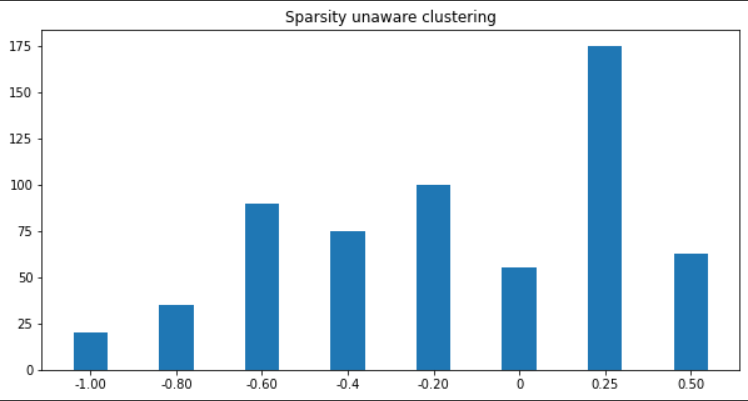

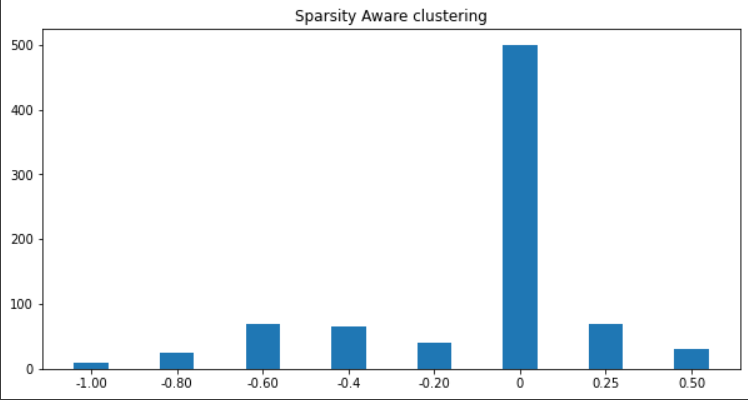

### Exercises (5.5 points)

Question 1 (2 points): Using the **first** link above and the content of all previous labs, write a function that applies weight clustering. Your function must take in 3 parameters (model, number of clusters and centroid initialization). Experiment and evaluate your model (size and accuracy) with 2 clusters and 16 clusters, and with  KMEANS_PLUS_PLUS centroid initialization and comment on your observations.

In [53]:
def weight_clustering(model, number_clusters, centroid_init):

    cluster_weights = tfmot.clustering.keras.cluster_weights
    CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

    if centroid_init == "LINEAR":
        clustering_params = {
            'number_of_clusters': number_clusters,
            'cluster_centroids_init': CentroidInitialization.LINEAR}
    elif centroid_init == "KMEANS_PLUS_PLUS":
        clustering_params = {
            'number_of_clusters': number_clusters,
            'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS}
    else:
        clustering_params = {
            'number_of_clusters': number_clusters,
            'cluster_centroids_init': CentroidInitialization.DENSITY_BASED}


    #apply the clustering API
    clustered_model = cluster_weights(model, **clustering_params)
    # Use smaller learning rate for fine-tuning clustered model
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    clustered_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=opt,
        metrics=['accuracy'])
    clustered_model.summary()

    #fine tune model
    clustered_model.fit(
      train_images,
      train_labels,
      batch_size=500,
      epochs=1,
      validation_split=0.1)

    #stripped model
    stripped_clustered_model = tfmot.clustering.keras.strip_clustering(clustered_model)
    return clustered_model, stripped_clustered_model

In [55]:
    model_to_cluster = tf.keras.models.load_model('trained_base_model.h5')

    ClusterdModel2, StrippedClusteredModel2 = weight_clustering(model_to_cluster, 2, "KMEANS_PLUS_PLUS")

    tf.keras.models.save_model(StrippedClusteredModel2, "clustered_model_2.h5", include_optimizer=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_flatten_1 (Cluster  (None, 784)               0         
 Weights)                                                        
                                                                 
 cluster_dense_2 (ClusterWe  (None, 128)               200834    
 ights)                                                          
                                                                 
 cluster_dropout_1 (Cluster  (None, 128)               0         
 Weights)                                                        
                                                                 
 cluster_dense_3 (ClusterWe  (None, 10)                2572      
 ights)                                                          
                                                                 
Total params: 203406 (1.16 MB)
Trainable params: 10177

<ipython-input-55-a3e2f8dda186>:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(StrippedClusteredModel2, "clustered_model_2.h5", include_optimizer=False)


In [56]:
    # 16 clusters
    model_to_cluster = tf.keras.models.load_model('trained_base_model.h5')


    ClusterdModel16, StrippedClusteredModel16 = weight_clustering(model_to_cluster, 16, "KMEANS_PLUS_PLUS")

    tf.keras.models.save_model(StrippedClusteredModel16, "clustered_model_16.h5", include_optimizer=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_flatten_1 (Cluster  (None, 784)               0         
 Weights)                                                        
                                                                 
 cluster_dense_2 (ClusterWe  (None, 128)               200848    
 ights)                                                          
                                                                 
 cluster_dropout_1 (Cluster  (None, 128)               0         
 Weights)                                                        
                                                                 
 cluster_dense_3 (ClusterWe  (None, 10)                2586      
 ights)                                                          
                                                                 
Total params: 203434 (1.16 MB)
Trainable params: 10180

<ipython-input-56-f6954887ff2e>:7: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(StrippedClusteredModel16, "clustered_model_16.h5", include_optimizer=False)


In [57]:
# Evaluate prediction accuracy
test_loss_clustered_2, test_acc_clustered_2 = ClusterdModel2.evaluate(test_images,  test_labels, verbose=0)
test_loss_clustered_16, test_acc_clustered_16 = ClusterdModel16.evaluate(test_images,  test_labels, verbose=0)
# Evaluate Inference Time of both
startTime = time.time()
prediction = ClusterdModel2.predict(test_images)
executionTimeClustered2 = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = ClusterdModel16.predict(test_images)
executionTimeClustered16 = (time.time() - startTime)/len(test_images)
# find model size
c2_model_size = get_gzipped_model_size('clustered_model_2.h5')
c16_model_size = get_gzipped_model_size('clustered_model_16.h5')
# Print
print('\2 Clustered Model Accuracy:', test_acc_clustered_2*100, '%')
print("2 Clustered Model Size: %.2f bytes" % (c2_model_size))
print("2 Clustered Inference Time is", executionTimeClustered2, "s")
print('\16 Clustered Model Accuracy:', test_acc_clustered_16*100, '%')
print("16 Clustered Model Size: %.2f bytes" % (c16_model_size))
print("16 Clustered Inference Time is", executionTimeClustered16, "s")

313/313 [==============================] - 1s 2ms/step
 Clustered Model Accuracy: 63.33000063896179 %
2 Clustered Model Size: 22806.00 bytes
2 Clustered Inference Time is 0.00014505577087402344 s
 Clustered Model Accuracy: 97.75000214576721 %
16 Clustered Model Size: 72071.00 bytes
16 Clustered Inference Time is 0.00014479331970214843 s


Comparing the two scenarios where we used different cluster amounts we ofund when we used 2 clusters we got a significantly lower accuracy score at 63.33% but the model size was significantly reduced. on the other hand in the 16 clusters model we recieved a veyr high accuracy score that improves upon the original training model at an accuracy of 97.5%, the trade off is seen by the increased model size. we can conclude the 2 cluster model does not suffice and overofuces on improving on function at the cost fo anoter very improtant result.

Question 2 (1 point): Using the resources present above and the content of all previous labs, apply weight clustering with iterative pruning (50% sparsity). Do this by calling your iterative pruning (Part1) followed by your weight clustering functions (of Part-3 Question 1). Print the final sparsity of your model and commment on it, and the performance and size versus what you observed in Q1.


In [58]:
model = tf.keras.models.load_model('trained_base_model.h5')

pruned_model_50, stripped_pruned_model_50 = iterative_pruning(model,0,0.95,1200 ,3500, train_images,train_labels,3)

pruned_clustered_model, stripped_pruned_clustered_model = weight_clustering(stripped_pruned_model_50, 16, "KMEANS_PLUS_PLUS")

tf.keras.models.save_model(stripped_pruned_clustered_model, "pruned_clustered_model.h5",include_optimizer=False)

print_model_weights_sparsity(stripped_pruned_clustered_model)

Epoch 1/3
1688/1688 [==============================] - 15s 8ms/step - loss: 0.0712 - accuracy: 0.9775 - val_loss: 0.0659 - val_accuracy: 0.9807
Epoch 2/3
1688/1688 [==============================] - 8s 5ms/step - loss: 0.3416 - accuracy: 0.8972 - val_loss: 0.3357 - val_accuracy: 0.9242
Epoch 3/3
1688/1688 [==============================] - 8s 5ms/step - loss: 0.5043 - accuracy: 0.8436 - val_loss: 0.2534 - val_accuracy: 0.9358
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cluster_flatten_1 (Cluster  (None, 784)               0         
 Weights)                                                        
                                                                 
 cluster_dense_2 (ClusterWe  (None, 128)               200848    
 ights)                                                          
                                                                 
 cluster_dropout_1 (

<ipython-input-58-ba70750db204>:7: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(stripped_pruned_clustered_model, "pruned_clustered_model.h5",include_optimizer=False)


kernel:0: 0.00% sparsity  (0/100352)
kernel:0: 0.00% sparsity  (0/1280)


In [59]:
test_loss_pruned_clustered, test_acc_pruned_clustered = pruned_clustered_model.evaluate(test_images,  test_labels, verbose=0)


# Evaluate Inference Time
startTime = time.time()
prediction = pruned_clustered_model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)


## Print without stripping
pc_model_size = get_gzipped_model_size('pruned_clustered_model.h5')

# Print
print('Clustered Model Accuracy:', test_acc_pruned_clustered*100, '%')
print("Clustered Model Size: %.2f bytes" % (pc_model_size))
print("Clustered Inference Time is", executionTime, "s")

313/313 [==============================] - 1s 2ms/step
Clustered Model Accuracy: 92.54000186920166 %
Clustered Model Size: 15383.00 bytes
Clustered Inference Time is 8.66891622543335e-05 s


in this scenario we find the overall accuracy score has now decreased to about 92.5% compared to the 16 cluster model earlier but the model size is also significantly smaller similar to the 2 cluster model but in this case a high accuracy score is maintained. the sparsity is 0% in both situations

Question 3 (2.5 points): Now apply iterative pruning (50% sparsity) followed by **sparsity preserving clustering** (https://www.tensorflow.org/model_optimization/guide/combine/sparse_clustering_example).

Print the final sparsity of your model and evaluate your final model. Compare the effects of combining the techniques together vs the techniques individually. Comment on how sparsity-preserving clustering differs from regular weight clustering.

In [62]:
model = tf.keras.models.load_model('trained_base_model.h5')
pruned_model_50, stripped_pruned_model_50 = iterative_pruning(model,0,0.5,1200 ,3500, train_images,train_labels,3)
from tensorflow_model_optimization.python.core.clustering.keras.experimental import (cluster,)

cluster_weights = cluster.cluster_weights

CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 16,
  'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS,
  'preserve_sparsity': True }

sparsity_clustered_model = cluster_weights(stripped_pruned_model_50, **clustering_params)

sparsity_clustered_model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

sparsity_clustered_model.fit(train_images, train_labels,epochs=3, validation_split=0.1)

stripped_sparsity_clustered_model = tfmot.clustering.keras.strip_clustering(sparsity_clustered_model)
tf.keras.models.save_model(stripped_sparsity_clustered_model, "sparsity_clustered_model.h5", include_optimizer=False)
print_model_weights_sparsity(stripped_sparsity_clustered_model)

Epoch 1/3
1688/1688 [==============================] - 9s 4ms/step - loss: 0.0709 - accuracy: 0.9777 - val_loss: 0.0683 - val_accuracy: 0.9790
Epoch 2/3
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0643 - accuracy: 0.9798 - val_loss: 0.0675 - val_accuracy: 0.9810
Epoch 3/3
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0546 - accuracy: 0.9830 - val_loss: 0.0650 - val_accuracy: 0.9827
Epoch 1/3
1688/1688 [==============================] - 11s 6ms/step - loss: 0.0270 - accuracy: 0.9919 - val_loss: 0.0759 - val_accuracy: 0.9807
Epoch 2/3
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0219 - accuracy: 0.9934 - val_loss: 0.0845 - val_accuracy: 0.9787
Epoch 3/3
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0180 - accuracy: 0.9948 - val_loss: 0.0870 - val_accuracy: 0.9783


<ipython-input-62-a4a55ede26fa>:23: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(stripped_sparsity_clustered_model, "sparsity_clustered_model.h5", include_optimizer=False)


kernel:0: 64.67% sparsity  (64896/100352)
kernel:0: 52.34% sparsity  (670/1280)


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tf_keras.src.initializers.initializers.GlorotUniform'>, which may lead to improper serialization.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tf_keras.src.initializers.initializers.Zeros'>, which may lead to improper serialization.
  warnings.warn(


In [63]:
test_loss_sparsity_clustered, test_acc_sparsity_clustered = sparsity_clustered_model.evaluate(test_images,  test_labels, verbose=0)


# Evaluate Inference Time
startTime = time.time()
prediction = sparsity_clustered_model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)


## Print without stripping
sc_model_size = get_gzipped_model_size('sparsity_clustered_model.h5')

# Print
print('Sparisty Clustered Model Accuracy:', test_acc_sparsity_clustered*100, '%')
print("Sparsity Clustered Model Size: %.2f bytes" % (sc_model_size))
print("Sparsity Clustered Inference Time is", executionTime, "s")

313/313 [==============================] - 1s 2ms/step
Sparisty Clustered Model Accuracy: 97.89000153541565 %
Sparsity Clustered Model Size: 48271.00 bytes
Sparsity Clustered Inference Time is 0.00010105228424072265 s


The sparsity of the model is now goinf form 64.67% to 52.34%
comparing the models when we took the 50% iterative pruning to the model we scored a 97.8% accuracy but had a massive model at over 300,000 bytes. the model was able to achieve 97.5% accuracy while having a model size of 72,071 bytes when the 16 clusters was applied. With combinging both intially we achieve 92% accuracy while having a model size of 15,383 bytes. When the two techniques were applied together, the accuracy remained at 97.89% but the size of the model decreased to 48,816 bytes. giving us an idela middle ground that optomizes accuracy and size

comparing regular weight clustering and sparsity perserving clustering, the first option still utilizes the weights that get pruned, vs the latter does not use them this means theyre gotten rid of and makes the model size smaller and our design more efficient.
